# KE5105 - Building Electrical Consumption Forecasting

# Modelling 6 - Preliminary model and Fine-tuning

## Summary of Findings
* Base 4x128 GRU 2x32 Dense
    * Min Validation MAE (normalised) = 1.753 (0.0255) @ epoch 88
* 4x128 GRU 2x32 Dense with dropouts (.2/.2)
    * Min Validation MAE = xxx (xxx) @ epoch xxx

## Load libraries

In [1]:
import os
os.chdir(os.path.join(os.path.sep, 'home', 'tkokkeng', 'Documents', 'KE5105', 'ETL'))
os.getcwd()

'/home/tkokkeng/Documents/KE5105/ETL'

In [2]:
import sys
if os.path.join(os.getcwd(), 'source') not in sys.path:
    sys.path.append(os.path.join(os.getcwd(), 'source'))
sys.path

['/home/tkokkeng/python/python367/tsfvenv/lib/python36.zip',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/lib-dynload',
 '/usr/lib/python3.6',
 '',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages',
 '/home/tkokkeng/.local/lib/python3.6/site-packages',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages/IPython/extensions',
 '/home/tkokkeng/.ipython',
 '/home/tkokkeng/Documents/KE5105/ETL/source']

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import datetime
import myUtilities as mu
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

from keras.models import Sequential, load_model
from keras import layers
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, TensorBoard

Using TensorFlow backend.


## Load data for building AS5

In [4]:
as5_train = mu.load_data_by_bldg(['AS5'], 'imputed_train')

In [5]:
as5_train[0][1].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31616 entries, 2015-06-12 08:00:00 to 2017-03-31 23:30:00
Data columns (total 17 columns):
PWMMainIC                         30018 non-null float64
PWMEXTAS4ExBldg                   30018 non-null float64
PWMAS4LanguageCenter              30018 non-null float64
PWMCANTEEN                        30018 non-null float64
PWMStreetLight                    30018 non-null float64
BTUAS5                            30029 non-null float64
PWMMainIC_30min_avg               29985 non-null float64
PWMEXTAS4ExBldg_30min_avg         29985 non-null float64
PWMAS4LanguageCenter_30min_avg    29985 non-null float64
PWMCANTEEN_30min_avg              29985 non-null float64
PWMStreetLight_30min_avg          29985 non-null float64
BTUAS5_30min_avg                  29998 non-null float64
PWM_sumadd                        29985 non-null float64
PWM_sumsubtract                   29985 non-null float64
PWM_30min_avg                     30027 non-null float64
B

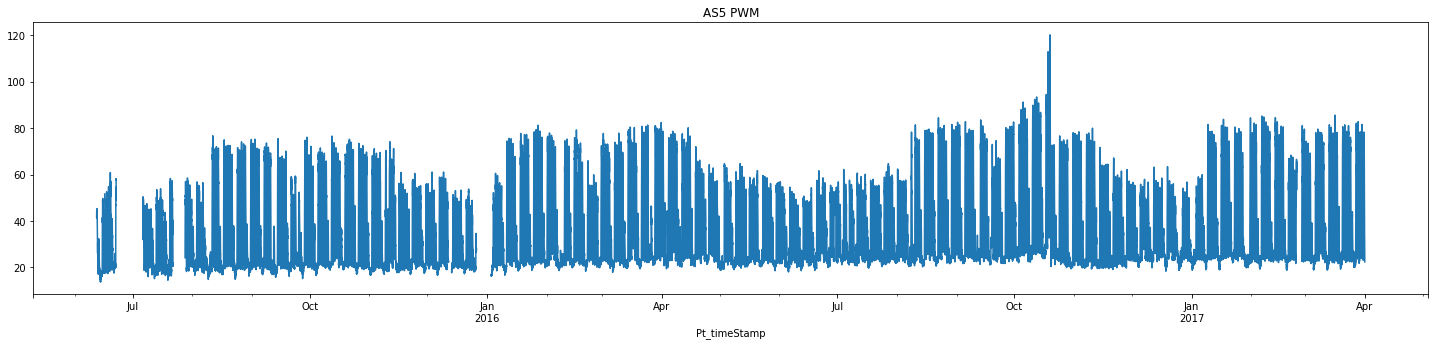

In [6]:
as5_train_df = as5_train[0][1]
as5_train_df['PWM_30min_avg'].plot(figsize=(25, 5), title='AS5 PWM')

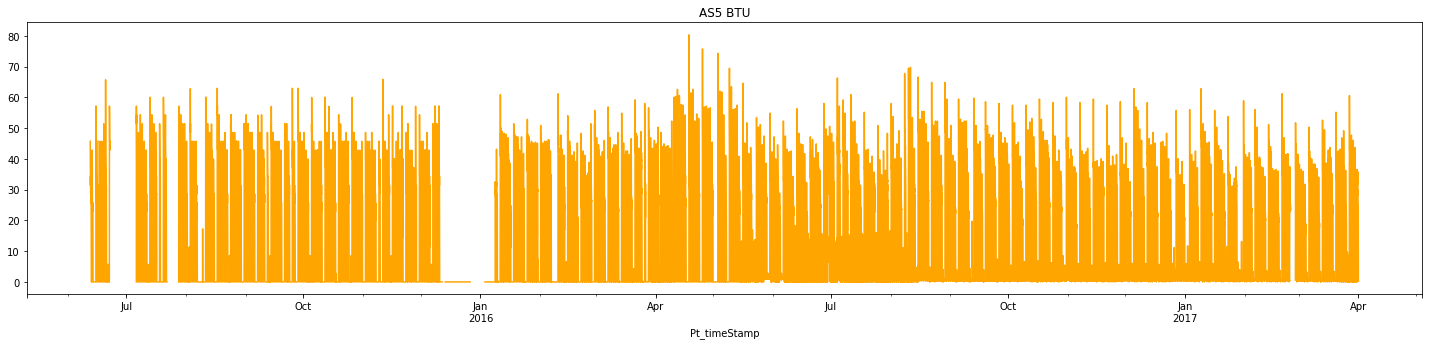

In [7]:
as5_train_df['BTU_30min_avg'].plot(figsize=(25, 5), title='AS5 BTU', color='orange')

## Split a validation set out from the train set

In [8]:
as5_train_split_df = as5_train_df[:20000]
as5_val_split_df = as5_train_df[20000:]

In [9]:
print('train split = %s\nvalidation split = %s' % (as5_train_split_df.shape, as5_val_split_df.shape))

train split = (20000, 17)
validation split = (11616, 17)


## Transform the training data

* Normalise the data - convert PWM and BTU values into the range 0 to 1
* Replace NaN with -1

In [10]:
# Create a transformation pipleline to prepare the training dataset for RNN.
attrbs = ['PWM_30min_avg', 'BTU_30min_avg']
my_pipeline = Pipeline([
    ('selector', mu.DataFrameSelector(attrbs)),
    # ('yeo-johnson_transform', PowerTransformer(method='yeo-johnson', standardize=False, copy=True)),
    ('minmax_scaler', MinMaxScaler()),
    ('na_transform', mu.Nan_to_Num_Transformer())
])

In [11]:
as5_train_data = my_pipeline.fit_transform(as5_train_split_df)
as5_train_data

array([[0.40696488, 0.56924225],
       [0.41425033, 0.53427896],
       [0.43450386, 0.53353241],
       ...,
       [0.15255719, 0.02140102],
       [0.16873088, 0.0390693 ],
       [0.15503424, 0.00348389]])

In [12]:
as5_train_data.shape

(20000, 2)

Text(0.5, 1.0, 'Normalised PWM Training Data')

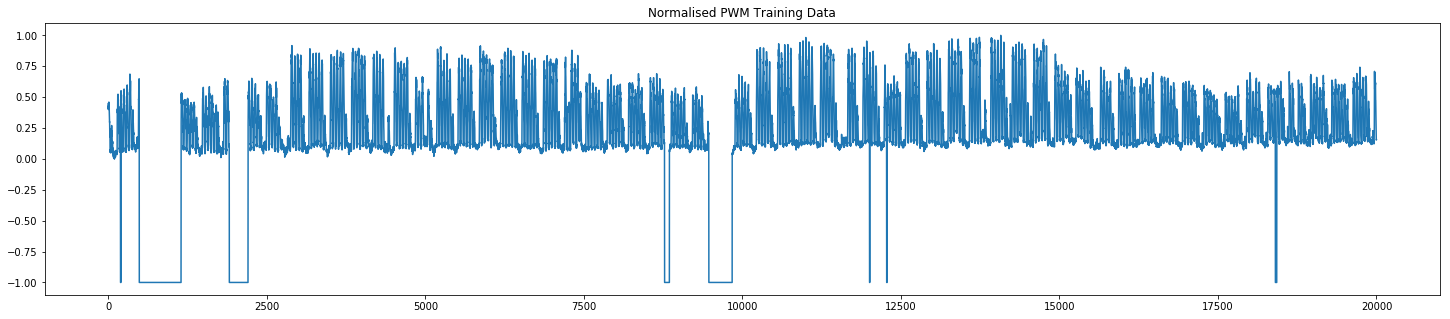

In [13]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0])
plt.title('Normalised PWM Training Data')

Text(0.5, 1.0, 'Normalised BTU Training Data')

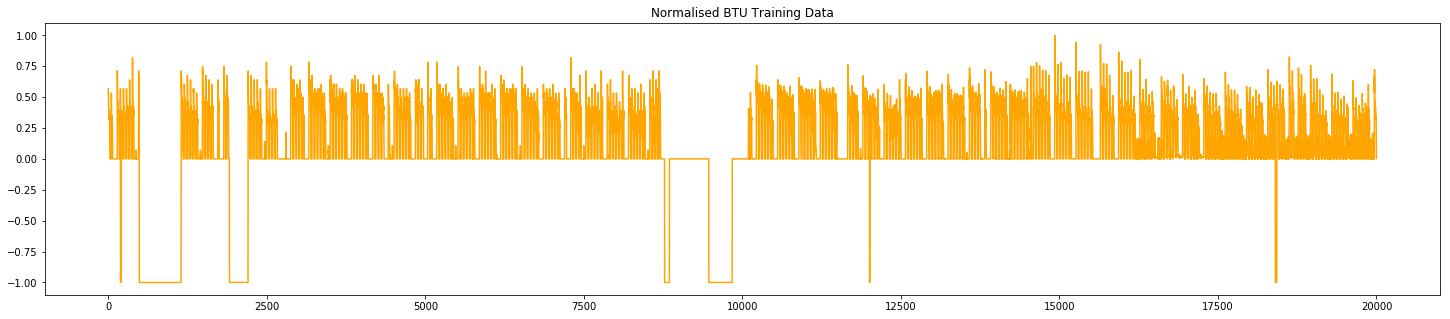

In [14]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 1], color='orange')
plt.title('Normalised BTU Training Data')

In [15]:
as5_val_data = my_pipeline.transform(as5_val_split_df)
as5_val_data

array([[1.52120064e-01, 2.15842164e-20],
       [1.56199913e-01, 2.15842164e-20],
       [1.60716888e-01, 1.99328108e-01],
       ...,
       [1.99912575e-01, 3.22259550e-02],
       [1.59842634e-01, 3.48388702e-03],
       [1.25570108e-01, 3.46599347e-03]])

In [16]:
as5_val_data.shape

(11616, 2)

Text(0.5, 1.0, 'Normalised PWM Validation Data')

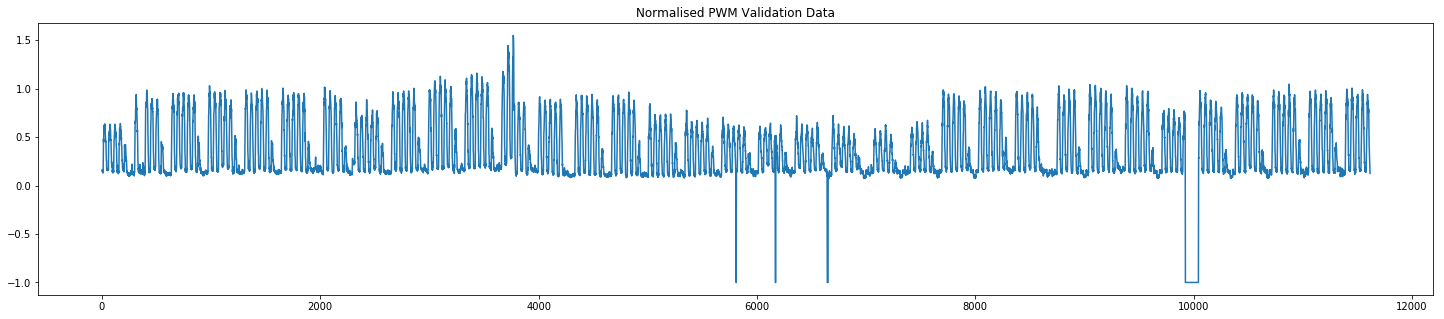

In [17]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_val_data.shape[0]), as5_val_data[:, 0])
plt.title('Normalised PWM Validation Data')

Text(0.5, 1.0, 'Normalised BTU Validation Data')

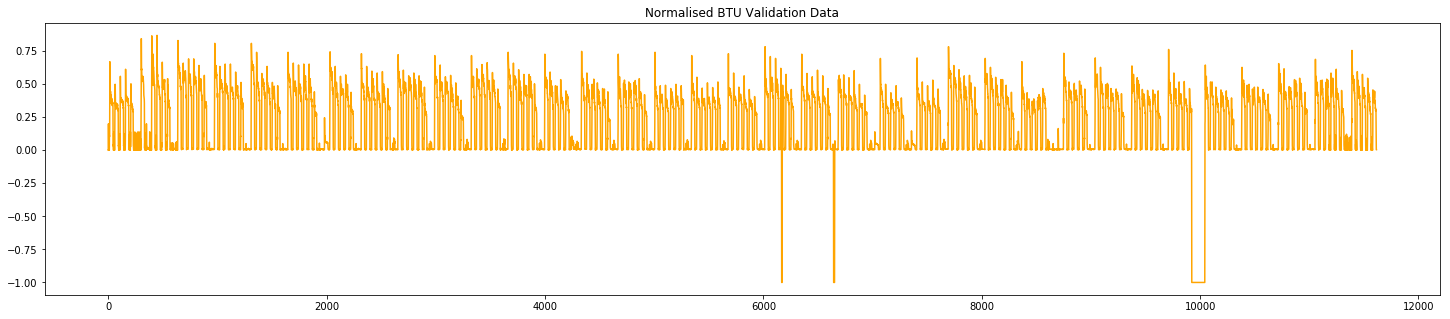

In [18]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_val_data.shape[0]), as5_val_data[:, 1], color='orange')
plt.title('Normalised BTU Validation Data')

## Parameters for the RNN model

Also used for generating the datasets with the lagged values 

In [19]:
lookback = 240  # 5 days; each day has 48 observations
step = 1  # sampling rate used for the lookback period
delay = 0  # 1 step ahead prediction
batch_size = 128

## 4x128 GRU, 2x32 Dense Layer Model 

In [20]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [21]:
model = Sequential()
model.add(layers.CuDNNGRU(128, return_sequences=True, input_shape=(None, as5_train_data.shape[-1])))
model.add(layers.CuDNNGRU(128, return_sequences=True))
model.add(layers.CuDNNGRU(128, return_sequences=True))
model.add(layers.CuDNNGRU(128))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [22]:
gen_train = mu.DataGenerator(as5_train_data,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                             batch_size=batch_size, step=step, shuffle=True)
gen_val = mu.DataGenerator(as5_val_data,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_data) - 1,
                           batch_size=batch_size, step=step)
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 144
test batches = 88


### Train the RNN

In [23]:
callbacks_list = [
    ModelCheckpoint(
        filepath='base3-4x128gru-2x32dense.best-epchxxx.h5',
        monitor='val_loss',
        save_best_only=True
    ),
    TensorBoard(
        log_dir='tsb_log'
    )
]

In [24]:
histories = []

In [25]:
# Temporary - to remove after training is completed
# Load previous history
# with open(os.path.join('models', 'base-4x128gru-2x32dense-epchxxx-histories.pkl'), 'rb') as infile:
#     histories = pickle.load(infile)
# Load previous model
# from keras.models import load_model
# model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-epchxxx.h5'))
# model.summary()

In [26]:
train_to_epoch = 300
start_epoch = 0
t1 = datetime.datetime.now()
print('Training start time = %s' % t1)
history = model.fit_generator(generator=gen_train, epochs=train_to_epoch,
                              callbacks=callbacks_list,
                              initial_epoch = start_epoch,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=0)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))
histories.append(history.history)

Training start time = 2019-03-04 15:47:54.712328

Training Duration = 1:01:30.643226


In [27]:
model.save('base3-4x128gru-2x32dense-epch' + str(train_to_epoch) + '.h5')

In [28]:
with open('base3-4x128gru-2x32dense-histories-epch' + str(train_to_epoch) + '.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

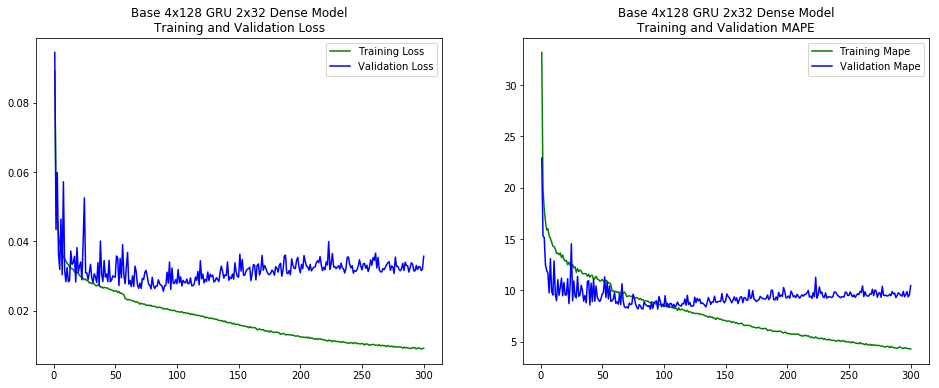

In [29]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)
    for a_mape in h['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in h['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Base 4x128 GRU 2x32 Dense Model\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('Base 4x128 GRU 2x32 Dense Model\nTraining and Validation MAPE')
plt.legend()
plt.show()

In [30]:
print('min validation loss = {}\nepoch = {}'.format(min(val_loss), val_loss.index(min(val_loss))))

min validation loss = 0.025540462347929824
epoch = 88


In [31]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_split_df['PWM_30min_avg'].max() - as5_train_split_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (as5_train_split_df['PWM_30min_avg'].max() - as5_train_split_df['PWM_30min_avg'].min()))))

Train MAE = 0.610106
Validation MAE = 1.752842


In [33]:
# Load best model
best_model = load_model(os.path.join('models', 'base3-4x128gru-2x32dense.best-epch88.h5'))
best_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, None, 128)         50688     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [34]:
gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = best_model.predict_generator(gen_pred, workers=3, use_multiprocessing=False)
as5_train_preds.shape

(18317, 1)

In [35]:
as5_train_preds1 = np.concatenate([as5_train_preds, np.zeros((as5_train_preds.shape[0], 1))], axis=1)
as5_train_preds1.shape

(18317, 2)

In [36]:
as5_train_preds1 = my_pipeline.inverse_transform(as5_train_preds1)
as5_train_preds1

array([[ 4.68488550e+01, -1.73472348e-18],
       [ 4.97395594e+01, -1.73472348e-18],
       [ 4.79356347e+01, -1.73472348e-18],
       ...,
       [ 2.44346058e+01, -1.73472348e-18],
       [ 2.53481448e+01, -1.73472348e-18],
       [ 2.49065655e+01, -1.73472348e-18]])

In [37]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if (as5_train_data[i, 0] > mu.MASK_VALUE) and (np.any(as5_train_data[i - lookback:i, 0] > mu.MASK_VALUE)):
        as5_train_preds_withnan[i] = as5_train_preds1[j, 0]
        j += 1
as5_train_preds_withnan.shape

(20000, 1)

In [38]:
gen_val_pred = mu.DataGenerator(as5_val_data,
                                lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_data) - 1,
                                batch_size=batch_size, step=step)
as5_val_preds = best_model.predict_generator(gen_val_pred, workers=3, use_multiprocessing=False)
as5_val_preds.shape

(11236, 1)

In [39]:
as5_val_preds1 = np.concatenate([as5_val_preds, np.zeros((as5_val_preds.shape[0], 1))], axis=1)
as5_val_preds1 = my_pipeline.inverse_transform(as5_val_preds1)
as5_val_preds_withnan = np.full((as5_val_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_val_data)):
    if (as5_val_data[i, 0] > mu.MASK_VALUE) and (np.any(as5_val_data[i - lookback:i, 0] > mu.MASK_VALUE)):
        as5_val_preds_withnan[i] = as5_val_preds1[j, 0]
        j += 1
as5_val_preds_withnan.shape

(11616, 1)

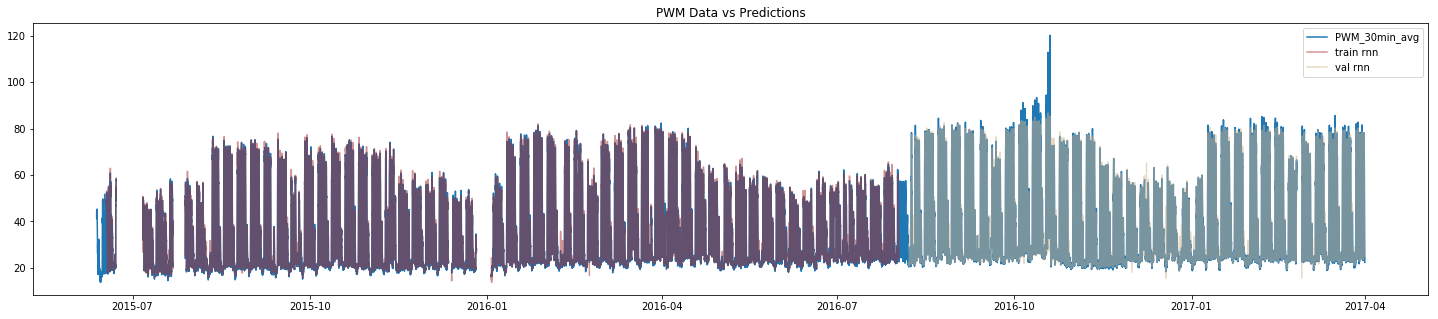

In [40]:
plt.figure(figsize=(25, 5))
plt.plot(as5_train_df['PWM_30min_avg'])
plt.plot(as5_train_df.index[:20000], as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.plot(as5_train_df.index[20000:], as5_val_preds_withnan.flatten(), color='tan', alpha=.5, label='val rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

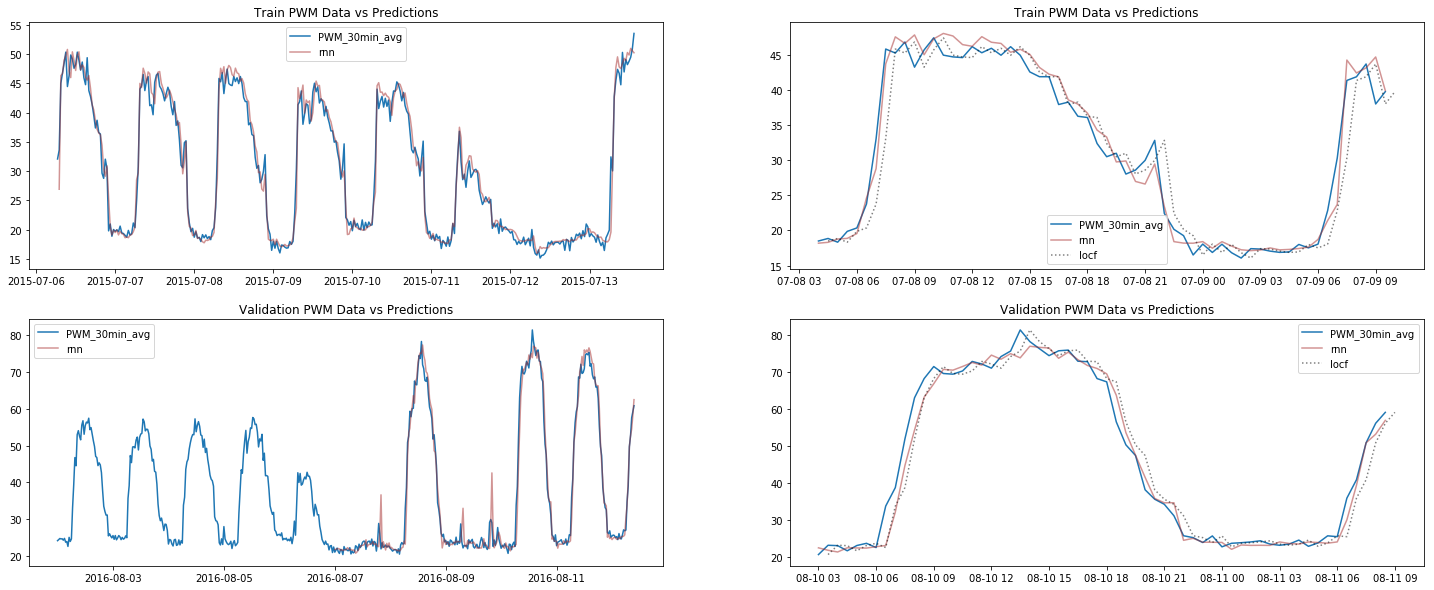

In [41]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(as5_train_df.iloc[1000:1500, as5_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(as5_train_df.index[1000:1500], as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(as5_train_df.iloc[1240:1300, as5_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(as5_train_df.index[1240:1300], as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(as5_train_df.index[1241:1301], as5_train_df.iloc[1240:1300, as5_train_df.columns.get_loc('PWM_30min_avg')].values, color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(as5_train_df.iloc[20000:20500, as5_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(as5_train_df.index[20000:20500], as5_val_preds_withnan[:500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(as5_train_df.iloc[20390:20450, as5_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(as5_train_df.index[20390:20450], as5_val_preds_withnan[390:450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(as5_train_df.index[20391:20451], as5_train_df.iloc[20390:20450, as5_train_df.columns.get_loc('PWM_30min_avg')].values, color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1
plt.title('Validation PWM Data vs Predictions')
plt.legend()

## 4x128 GRU, 2x32 Dense Model with Dropout (0.2) and Recurrent Dropout (0.2)

In [20]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [21]:
model = Sequential()
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.2, recurrent_dropout=0.2, return_sequences=True, reset_after=True, input_shape=(None, as5_train_data.shape[-1])))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.2, recurrent_dropout=0.2, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.2, recurrent_dropout=0.2, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.2, recurrent_dropout=0.2, reset_after=True))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 128)         50688     
_________________________________________________________________
gru_2 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_3 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_4 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [21]:
gen_train = mu.DataGenerator(as5_train_data,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_data,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_data) - 1,
                           batch_size=batch_size, step=step)
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 144
test batches = 88


In [23]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base1-4x128gru-2x32dense-dropout0202-histories-epch100.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base1-4x128gru-2x32dense-dropout0202-epch100.h5'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 128)         50688     
_________________________________________________________________
gru_2 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_3 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_4 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [24]:
callbacks_list = [
    ModelCheckpoint(
        # filepath='base-4x128gru-2x32dense-wgtl1l2-1e-7-actl1-1e-7.{epoch:02d}-{val_loss:.2f}.h5',
        filepath='base1-4x128gru-2x32dense-dropout0202.best.h5',
        monitor='val_loss',
        save_best_only=True
    ),
    TensorBoard(
        log_dir='tsb_log'
    )
]

In [25]:
t1 = datetime.datetime.now()
print('Training start time = {}'.format(t1))
history = model.fit_generator(generator=gen_train, epochs=100,
                              callbacks=callbacks_list,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=0)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Training start time = 2019-02-21 15:05:01.205077

Training Duration = 2:37:11.473046


In [28]:
# histories = []  # for 1st training session only
histories.append(history.history)

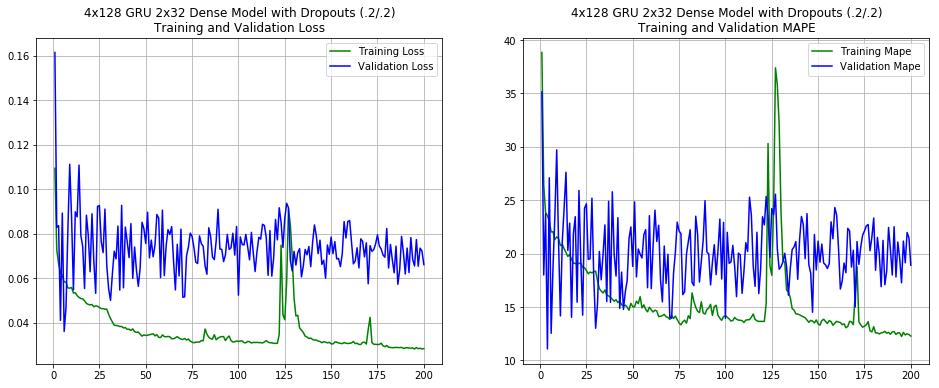

In [29]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)
    for a_mape in h['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in h['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts (.2/.2)\nTraining and Validation Loss')
plt.grid(True)
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts (.2/.2)\nTraining and Validation MAPE')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
print('Train min loss = %f\nValidation min loss = %f\nValidation min epoch = %d' %
      (min(train_loss),
       min(val_loss),
       val_loss.index(min(val_loss))))

Train min loss = 0.028174
Validation min loss = 0.036038
Validation min epoch = 5


In [31]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_split_df['PWM_30min_avg'].max() - as5_train_split_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (as5_train_split_df['PWM_30min_avg'].max() - as5_train_split_df['PWM_30min_avg'].min()))))

Train MAE = 1.933558
Validation MAE = 2.473295


In [32]:
# Load best model
best_model = load_model(os.path.join('models', 'base1-4x128gru-2x32dense-dropout0202.best.h5'))
best_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 128)         50688     
_________________________________________________________________
gru_2 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_3 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_4 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [33]:
gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = best_model.predict_generator(gen_pred, workers=3, use_multiprocessing=False)
as5_train_preds.shape

(18320, 1)

In [34]:
as5_train_preds1 = np.concatenate([as5_train_preds, np.zeros((as5_train_preds.shape[0], 1))], axis=1)
as5_train_preds1.shape

(18320, 2)

In [35]:
as5_train_preds1 = my_pipeline.inverse_transform(as5_train_preds1)
as5_train_preds1

array([[ 5.01938403e+01, -1.73472348e-18],
       [ 5.15574477e+01, -1.73472348e-18],
       [ 4.74904413e+01, -1.73472348e-18],
       ...,
       [ 2.50957629e+01, -1.73472348e-18],
       [ 2.17525448e+01, -1.73472348e-18],
       [ 2.24517431e+01, -1.73472348e-18]])

In [36]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if as5_train_data[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds1[j, 0]
        j += 1
as5_train_preds_withnan.shape

(20000, 1)

In [37]:
gen_val_pred = mu.DataGenerator(as5_val_data,
                                lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_data) - 1,
                                batch_size=batch_size, step=step)
as5_val_preds = best_model.predict_generator(gen_val_pred, workers=3, use_multiprocessing=False)
as5_val_preds.shape

(11236, 1)

In [38]:
as5_val_preds1 = np.concatenate([as5_val_preds, np.zeros((as5_val_preds.shape[0], 1))], axis=1)
as5_val_preds1 = my_pipeline.inverse_transform(as5_val_preds1)
as5_val_preds_withnan = np.full((as5_val_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_val_data)):
    if as5_val_data[i, 0] > -1:
        as5_val_preds_withnan[i] = as5_val_preds1[j, 0]
        j += 1
as5_val_preds_withnan.shape

(11616, 1)

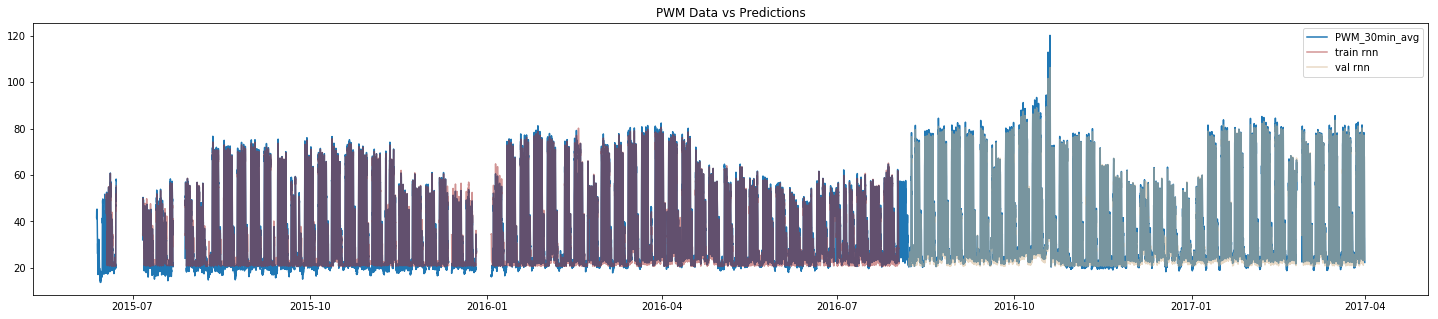

In [39]:
plt.figure(figsize=(25, 5))
plt.plot(as5_train_df['PWM_30min_avg'])
plt.plot(as5_train_df.index[:20000], as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.plot(as5_train_df.index[20000:], as5_val_preds_withnan.flatten(), color='tan', alpha=.5, label='val rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

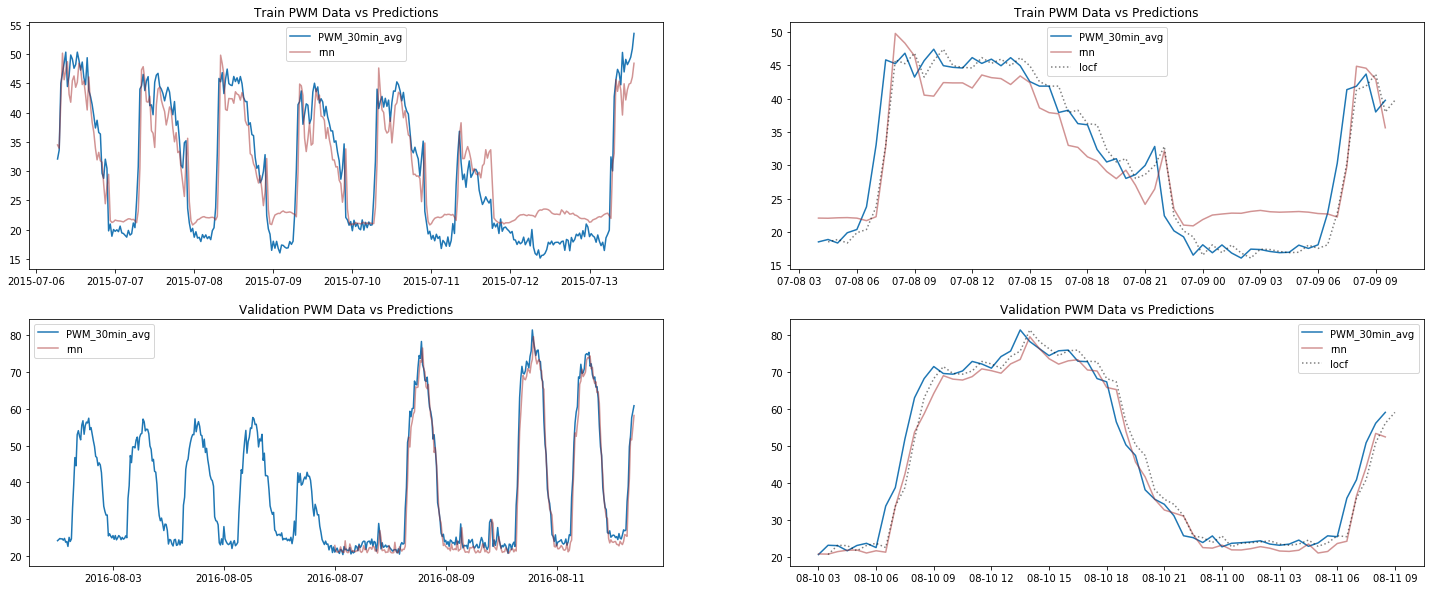

In [40]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(as5_train_df.iloc[1000:1500, as5_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(as5_train_df.index[1000:1500], as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(as5_train_df.iloc[1240:1300, as5_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(as5_train_df.index[1240:1300], as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(as5_train_df.index[1241:1301], as5_train_df.iloc[1240:1300, as5_train_df.columns.get_loc('PWM_30min_avg')].values, color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(as5_train_df.iloc[20000:20500, as5_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(as5_train_df.index[20000:20500], as5_val_preds_withnan[:500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(as5_train_df.iloc[20390:20450, as5_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(as5_train_df.index[20390:20450], as5_val_preds_withnan[390:450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(as5_train_df.index[20391:20451], as5_train_df.iloc[20390:20450, as5_train_df.columns.get_loc('PWM_30min_avg')].values, color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [32]:
model.save('base1-4x128gru-2x32dense-dropout0202.h5')

In [33]:
with open('base1-4x128gru-2x32dense-dropout0202-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

# ============= All below to be edited ============== 

## 4x128 GRU, 2x32 Dense Model with Dropout (0.2) and No Recurrent Dropout

In [20]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [20]:
model = Sequential()
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.2, return_sequences=True, reset_after=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.2, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.2, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', dropout=0.2, reset_after=True))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])


In [21]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)

In [22]:
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 143
test batches = 88


In [33]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base-4x128gru-2x32dense-dropout0200-histories.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-dropout0200.h5'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 128)         50688     
_________________________________________________________________
gru_2 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_3 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
gru_4 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [23]:
t1 = datetime.datetime.now()
history = model.fit_generator(generator=gen_train, epochs=50,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=True, shuffle=True, verbose=2)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Epoch 1/50
 - 86s - loss: 0.0843 - mean_absolute_percentage_error: 51.2702 - val_loss: 0.0604 - val_mean_absolute_percentage_error: 23.5358
Epoch 2/50
 - 83s - loss: 0.0605 - mean_absolute_percentage_error: 37.4005 - val_loss: 0.0900 - val_mean_absolute_percentage_error: 38.3364
Epoch 3/50
 - 83s - loss: 0.0513 - mean_absolute_percentage_error: 30.8312 - val_loss: 0.0938 - val_mean_absolute_percentage_error: 30.6236
Epoch 4/50
 - 83s - loss: 0.0475 - mean_absolute_percentage_error: 29.5986 - val_loss: 0.0268 - val_mean_absolute_percentage_error: 12.9550
Epoch 5/50
 - 83s - loss: 0.0444 - mean_absolute_percentage_error: 28.0224 - val_loss: 0.0522 - val_mean_absolute_percentage_error: 18.3554
Epoch 6/50
 - 83s - loss: 0.0426 - mean_absolute_percentage_error: 26.0586 - val_loss: 0.0737 - val_mean_absolute_percentage_error: 29.8102
Epoch 7/50
 - 83s - loss: 0.0407 - mean_absolute_percentage_error: 25.3983 - val_loss: 0.0558 - val_mean_absolute_percentage_error: 20.8350
Epoch 8/50
 - 83s - 

In [25]:
histories.append(history.history)

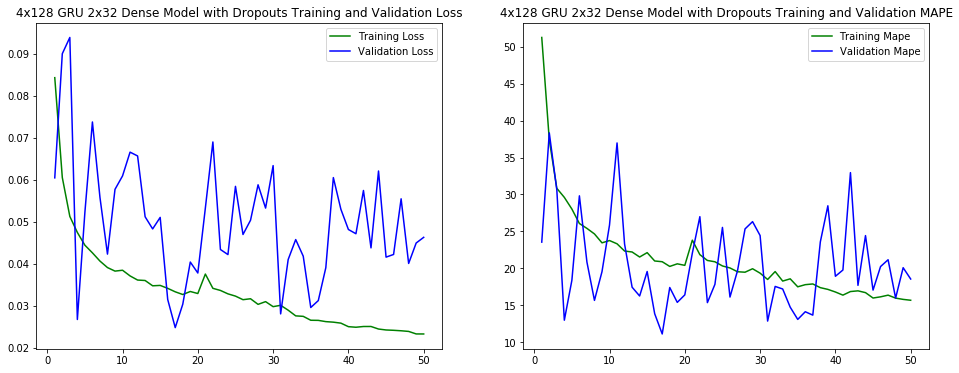

In [38]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for history in histories:
    for a_loss in history['loss']:
        train_loss.append(a_loss)
    for a_loss in history['val_loss']:
        val_loss.append(a_loss)
    for a_mape in history['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in history['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts Training and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts Training and Validation MAPE')
plt.legend()
plt.show()

In [29]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 2.480317
Validation MAE = 2.641168


In [27]:
gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = model.predict_generator(gen_pred, workers=3, use_multiprocessing=True)
as5_train_preds.shape

(18304, 1)

In [28]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if as5_train_data[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

(20000, 1)

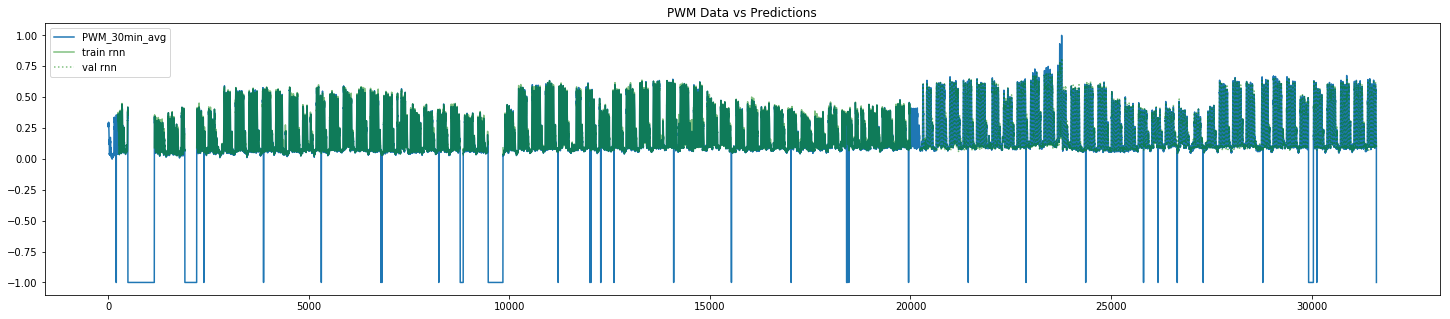

In [31]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_data.shape[0]), as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

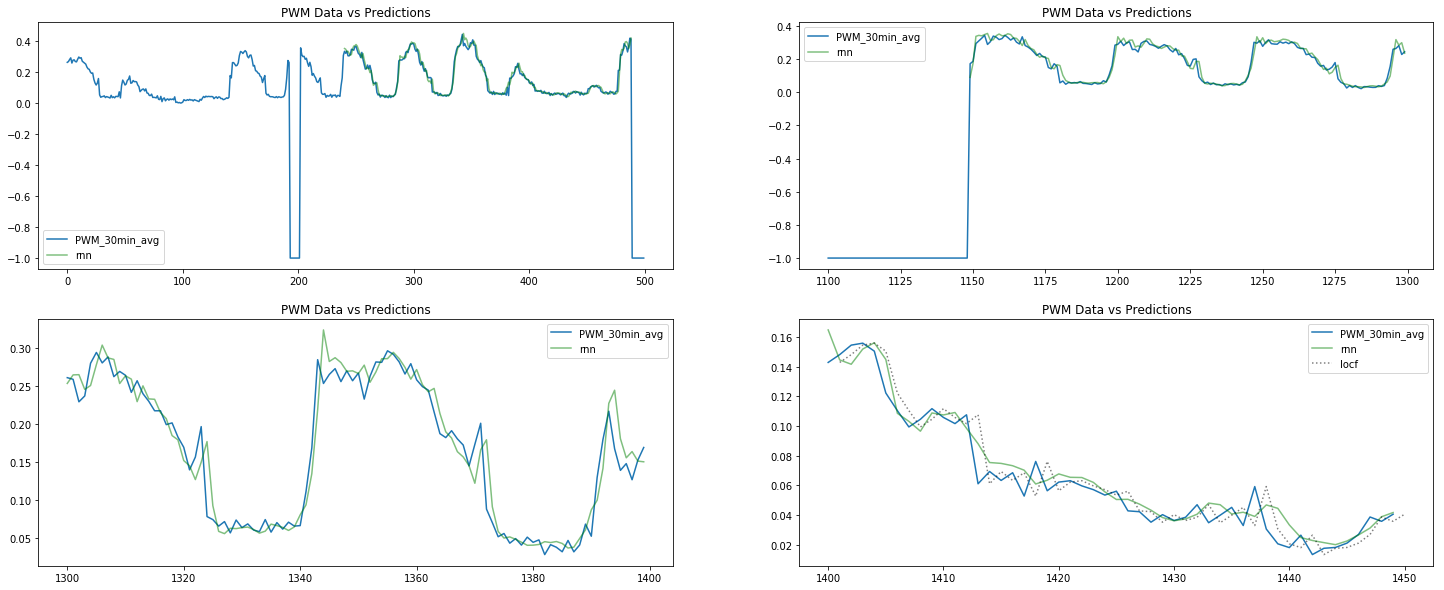

In [32]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), as5_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), as5_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), as5_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), as5_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), as5_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), as5_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), as5_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), as5_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [27]:
model.save('base-4x128gru-2x32dense-dropout0200.h5')

In [28]:
with open('base-4x128gru-2x32dense-dropout0200-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

## 4x128 GRU, 2x32 Dense Model with No Dropout and Recurrent Dropout (0.2)

In [19]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [20]:
model = Sequential()
model.add(layers.GRU(128, recurrent_activation='sigmoid', recurrent_dropout=0.2, return_sequences=True, reset_after=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.GRU(128, recurrent_activation='sigmoid', recurrent_dropout=0.2, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', recurrent_dropout=0.2, return_sequences=True, reset_after=True))
model.add(layers.GRU(128, recurrent_activation='sigmoid', recurrent_dropout=0.2, reset_after=True))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [21]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)

In [22]:
print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 143
test batches = 88


In [ ]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base-4x128gru-2x32dense-dropout0002-histories.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-dropout0002.h5'))
model.summary()

In [49]:
t1 = datetime.datetime.now()
history = model.fit_generator(generator=gen_train, epochs=50,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=True, shuffle=True, verbose=2)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Epoch 1/50
Epoch 1/50
Epoch 1/50
 - 87s - loss: 0.0158 - mean_absolute_percentage_error: 10.8200 - val_loss: 0.0188 - val_mean_absolute_percentage_error: 8.8066
Epoch 2/50
 - 88s - loss: 0.0157 - mean_absolute_percentage_error: 10.5927 - val_loss: 0.0192 - val_mean_absolute_percentage_error: 9.3073
Epoch 3/50
 - 88s - loss: 0.0157 - mean_absolute_percentage_error: 10.7837 - val_loss: 0.0227 - val_mean_absolute_percentage_error: 9.6431
Epoch 4/50
 - 88s - loss: 0.0156 - mean_absolute_percentage_error: 10.8850 - val_loss: 0.0208 - val_mean_absolute_percentage_error: 9.6518
Epoch 5/50
 - 87s - loss: 0.0156 - mean_absolute_percentage_error: 10.9558 - val_loss: 0.0203 - val_mean_absolute_percentage_error: 9.6858
Epoch 6/50
 - 87s - loss: 0.0155 - mean_absolute_percentage_error: 10.7372 - val_loss: 0.0197 - val_mean_absolute_percentage_error: 9.1714
Epoch 7/50
 - 87s - loss: 0.0156 - mean_absolute_percentage_error: 10.7732 - val_loss: 0.0242 - val_mean_absolute_percentage_error: 13.9883
Epoc

In [50]:
# histories = []  ## if first training session
histories.append(history.history)

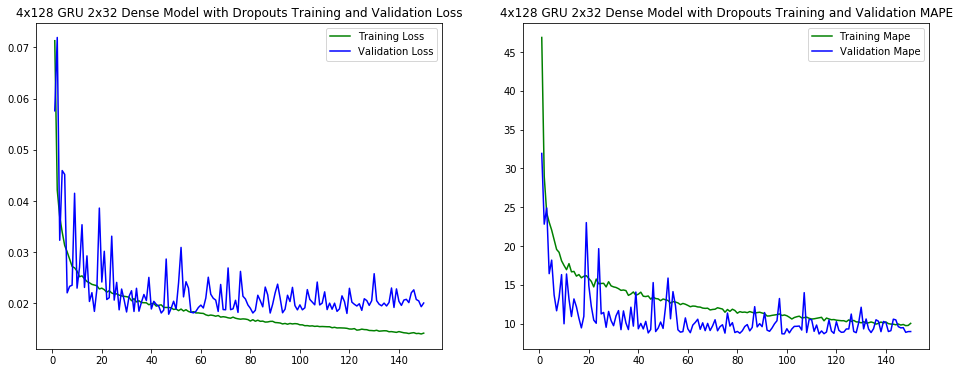

In [51]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for history in histories:
    for a_loss in history['loss']:
        train_loss.append(a_loss)
    for a_loss in history['val_loss']:
        val_loss.append(a_loss)
    for a_mape in history['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in history['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts Training and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts Training and Validation MAPE')
plt.legend()
plt.show()

In [52]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 1.493735
Validation MAE = 1.904215


In [53]:
gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = model.predict_generator(gen_pred, workers=3, use_multiprocessing=True)
as5_train_preds.shape

(29754, 1)

In [54]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if as5_train_data[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

(31616, 1)

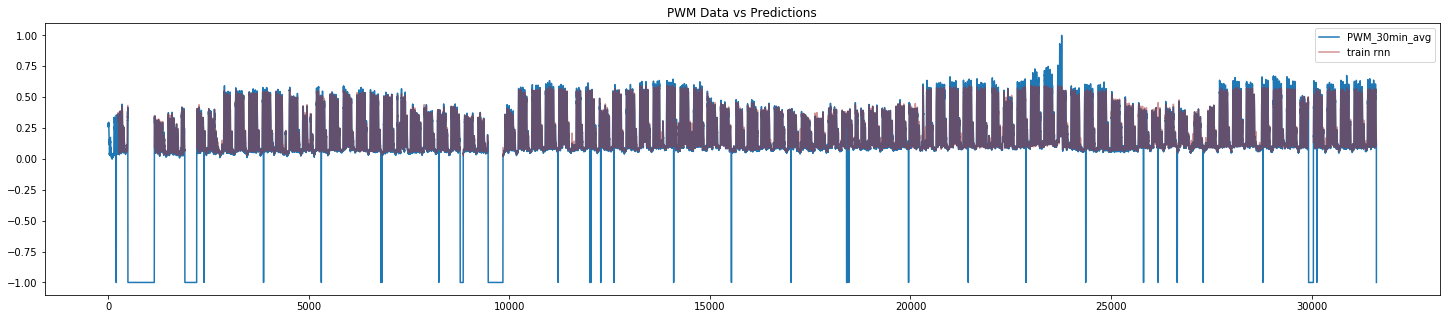

In [55]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_data.shape[0]), as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

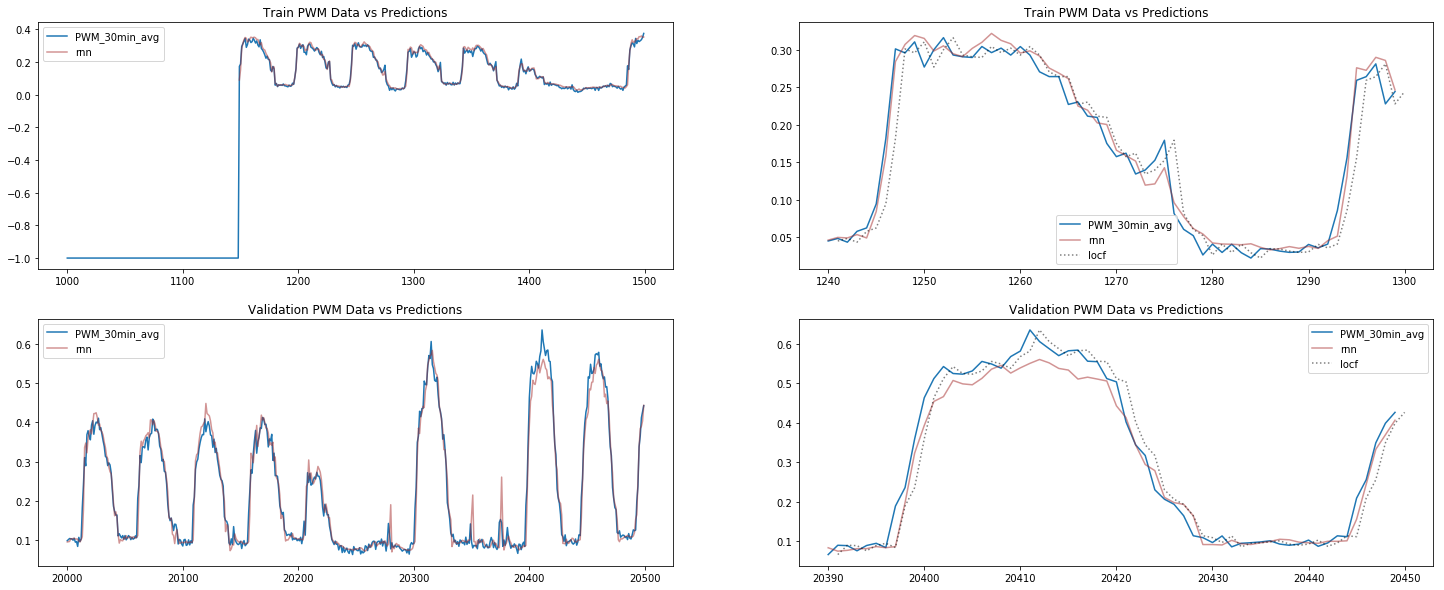

In [56]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), as5_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), as5_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), as5_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), as5_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), as5_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), as5_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), as5_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), as5_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [57]:
model.save('base-4x128gru-2x32dense-dropout0002.h5')

In [58]:
with open('base-4x128gru-2x32dense-dropout0002-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)